<a href="https://colab.research.google.com/github/ayushpatra11/CV_CW/blob/main/Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install opencv-python numpy scikit-learn matplotlib

In [1]:
import numpy as np
import cv2 as cv
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.datasets import cifar10, cifar100

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

def resize_images(images, target_size=(128, 128)):
  return np.array([cv.resize(img, target_size) for img in images])

x_train_resized = resize_images(x_train)
x_test_resized = resize_images(x_test)

x_train_resized = x_train_resized[:5000]
x_test_resized = x_test_resized[:200]
y_train = y_train[:5000].flatten()
y_test = y_test[:200].flatten()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


In [5]:
from sklearn.preprocessing import normalize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import numpy as np
import cv2

best_acc = 0
best_params = None

def run_bow_svm_experiment(k_clusters=100, svm_kernel='linear', C=1.0):
    # Create SIFT detector
    sift = cv2.SIFT_create()
    descriptors_list = []

    for img in x_train_resized:
        kp, des = sift.detectAndCompute(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), None)
        if des is not None:
            descriptors_list.append(des)

    all_desc = np.vstack(descriptors_list)
    kmeans = KMeans(n_clusters=k_clusters, random_state=42)
    kmeans.fit(all_desc)

    def compute_bow_histogram(image):
        kp, des = sift.detectAndCompute(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), None)
        if des is None:
            return np.zeros(k_clusters)
        cluster_result = kmeans.predict(des)
        hist, _ = np.histogram(cluster_result, bins=np.arange(k_clusters + 1))
        return hist

    X_train_bow = np.array([compute_bow_histogram(img) for img in x_train_resized])
    X_test_bow = np.array([compute_bow_histogram(img) for img in x_test_resized])

    # Normalize
    X_train_bow = normalize(X_train_bow, norm='l2')
    X_test_bow = normalize(X_test_bow, norm='l2')

    # Train SVM
    svm = SVC(kernel=svm_kernel, C=C)
    svm.fit(X_train_bow, y_train)
    y_pred = svm.predict(X_test_bow)
    acc = accuracy_score(y_test, y_pred)
    print(f"k={k_clusters}, kernel={svm_kernel}, C={C} → Accuracy: {acc:.4f}")
    return svm, kmeans, acc

In [6]:
import joblib
import numpy as np
results = []
for k in [50, 100, 200]:
    for kernel in ['linear', 'rbf']:
        for C in [0.1, 1]:
            svm, kmeans, acc = run_bow_svm_experiment(k_clusters=k, svm_kernel=kernel, C=C)
            if acc > best_acc:
                best_acc = acc
                joblib.dump(svm, "best_svm_bow_model.pkl")
                joblib.dump(kmeans, "best_kmeans_vocab.pkl")
                print(f"Saved new best model with acc={acc:.4f}")
            results.append((k, kernel, C, acc))

k=50, kernel=linear, C=0.1 → Accuracy: 0.2250
Saved new best model with acc=0.2250
k=50, kernel=linear, C=1 → Accuracy: 0.2400
Saved new best model with acc=0.2400
k=50, kernel=rbf, C=0.1 → Accuracy: 0.2200
k=50, kernel=rbf, C=1 → Accuracy: 0.2250
k=100, kernel=linear, C=0.1 → Accuracy: 0.2550
Saved new best model with acc=0.2550
k=100, kernel=linear, C=1 → Accuracy: 0.2300
k=100, kernel=rbf, C=0.1 → Accuracy: 0.2300
k=100, kernel=rbf, C=1 → Accuracy: 0.2600
Saved new best model with acc=0.2600
k=200, kernel=linear, C=0.1 → Accuracy: 0.2350
k=200, kernel=linear, C=1 → Accuracy: 0.2250
k=200, kernel=rbf, C=0.1 → Accuracy: 0.2200
k=200, kernel=rbf, C=1 → Accuracy: 0.2250


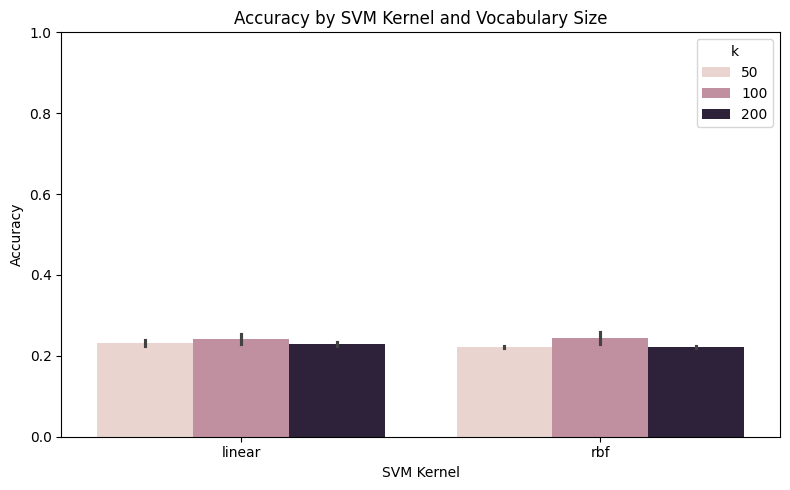

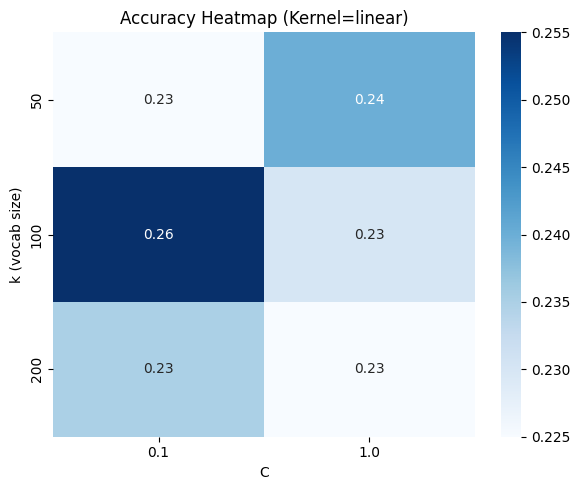

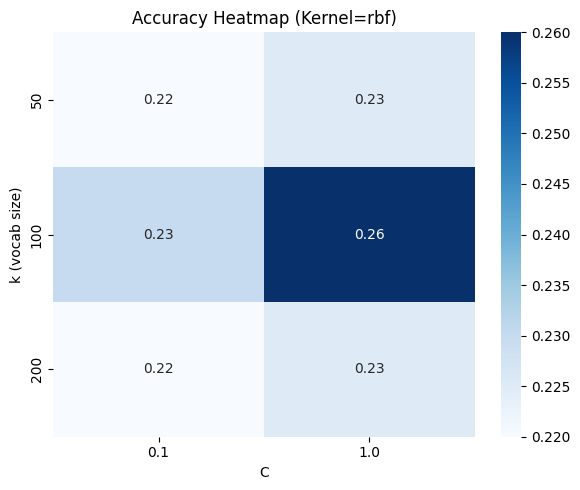

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(results, columns=["k", "kernel", "C", "Accuracy"])

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(data=df, x="kernel", y="Accuracy", hue="k")
plt.title("Accuracy by SVM Kernel and Vocabulary Size")
plt.xlabel("SVM Kernel")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend(title="k")
plt.tight_layout()
plt.show()

# Accuracy heatmap for each kernel
for kern in df['kernel'].unique():
    pivot = df[df['kernel'] == kern].pivot(index='k', columns='C', values='Accuracy')
    plt.figure(figsize=(6, 5))
    sns.heatmap(pivot, annot=True, cmap='Blues', fmt=".2f")
    plt.title(f"Accuracy Heatmap (Kernel={kern})")
    plt.xlabel("C")
    plt.ylabel("k (vocab size)")
    plt.tight_layout()
    plt.show()

In [8]:
def compute_bow_histogram(image, sift, kmeans, k):
    kp, des = sift.detectAndCompute(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), None)
    if des is None:
        return np.zeros(k)
    cluster_result = kmeans.predict(des)
    hist, _ = np.histogram(cluster_result, bins=np.arange(k + 1))
    return hist

# Create histograms for test data
k = kmeans.n_clusters
X_test_bow = np.array([compute_bow_histogram(img, sift, kmeans, k) for img in x_test_resized])

from sklearn.preprocessing import normalize
X_test_bow = normalize(X_test_bow, norm='l2')

NameError: name 'sift' is not defined

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

y_pred = svm.predict(X_test_bow)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=classes))

NameError: name 'X_test_bow' is not defined

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix - BoW + SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

NameError: name 'y_pred' is not defined

In [11]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred)
x = np.arange(len(classes))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, precision, width=0.4, label='Precision')
plt.bar(x + 0.2, recall, width=0.4, label='Recall')
plt.xticks(x, classes)
plt.title("Precision and Recall per Class")
plt.xlabel("Class")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'y_pred' is not defined

In [12]:
idx = 0
hist = compute_bow_histogram(x_test_resized[idx], sift, kmeans, k)

plt.bar(range(k), hist)
plt.title(f"Visual Word Histogram - Test Image {idx}")
plt.xlabel("Visual Word Index")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

NameError: name 'sift' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

subset_size = 5000
classes = trainset.classes
trainset = torch.utils.data.Subset(trainset, range(subset_size))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torchvision.models as models

mobilenet = models.mobilenet_v3_large(pretrained=True)

# Freeze feature layers
for param in mobilenet.features.parameters():
    param.requires_grad = False

mobilenet.classifier[3] = nn.Sequential(
    nn.Linear(mobilenet.classifier[3].in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.6),  # stronger dropout
    nn.Linear(256, 10)
)

mobilenet = mobilenet.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [ ]:
num_epochs = 10
train_acc_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct, total = 0, 0
    mobilenet.train()

    print(f"\nEpoch {epoch+1}/{num_epochs} started...")

    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mobilenet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Print progress every 100 batches
        if (i + 1) % 100 == 0 or (i + 1) == len(trainloader):
            print(f"  Batch {i+1}/{len(trainloader)} - Loss: {loss.item():.4f}")
    scheduler.step()

    acc = correct / total
    train_acc_list.append(acc)
    print(f"Epoch {epoch+1} completed — Loss: {running_loss:.3f}, Accuracy: {acc:.4f}")


Epoch 1/10 started...
  Batch 79/79 - Loss: 1.8609
Epoch 1 completed — Loss: 158.139, Accuracy: 0.3808

Epoch 2/10 started...
  Batch 79/79 - Loss: 0.4520
Epoch 2 completed — Loss: 95.876, Accuracy: 0.6328

Epoch 3/10 started...
  Batch 79/79 - Loss: 1.3829
Epoch 3 completed — Loss: 71.880, Accuracy: 0.7100

Epoch 4/10 started...
  Batch 79/79 - Loss: 0.5235
Epoch 4 completed — Loss: 62.212, Accuracy: 0.7404

Epoch 5/10 started...
  Batch 79/79 - Loss: 0.2301
Epoch 5 completed — Loss: 56.283, Accuracy: 0.7592

Epoch 6/10 started...
  Batch 79/79 - Loss: 1.5950
Epoch 6 completed — Loss: 54.221, Accuracy: 0.7806

Epoch 7/10 started...
  Batch 79/79 - Loss: 0.6218
Epoch 7 completed — Loss: 51.866, Accuracy: 0.7824

Epoch 8/10 started...
  Batch 79/79 - Loss: 0.5619
Epoch 8 completed — Loss: 49.662, Accuracy: 0.7862

Epoch 9/10 started...
  Batch 79/79 - Loss: 1.3623
Epoch 9 completed — Loss: 49.406, Accuracy: 0.7992

Epoch 10/10 started...
  Batch 79/79 - Loss: 1.2466
Epoch 10 completed 

Test Accuracy: 0.7879
              precision    recall  f1-score   support

    airplane       0.77      0.80      0.78      1000
  automobile       0.92      0.84      0.88      1000
        bird       0.73      0.76      0.74      1000
         cat       0.69      0.56      0.61      1000
        deer       0.71      0.78      0.74      1000
         dog       0.69      0.77      0.73      1000
        frog       0.85      0.82      0.84      1000
       horse       0.83      0.79      0.81      1000
        ship       0.84      0.87      0.85      1000
       truck       0.86      0.90      0.88      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



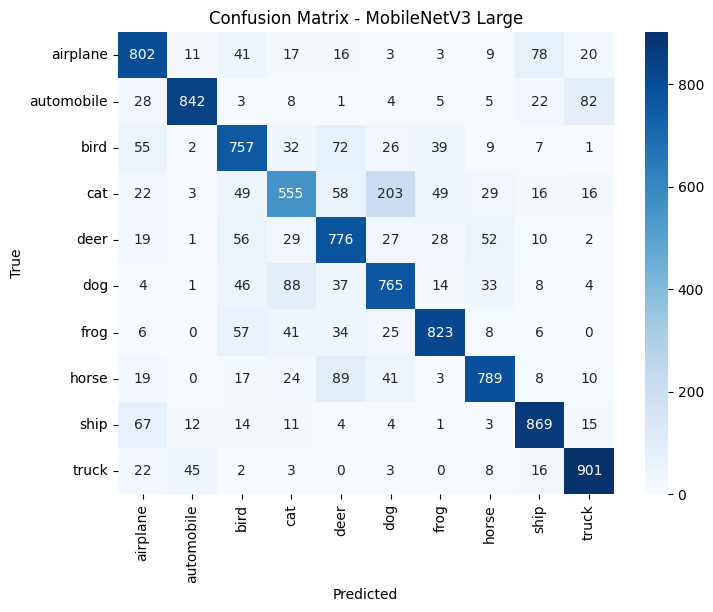

In [ ]:
mobilenet.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        outputs = mobilenet(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - MobileNetV3 Large')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()